In [2]:
import pandas as pd
import numpy
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data, iris.target
pca = PCA().fit(X)
print 'Explained variance by component: %s' %(pca.explained_variance_ratio_)
print pd.DataFrame(pca.components_,columns=iris.feature_names)

Explained variance by component: [ 0.92461621  0.05301557  0.01718514  0.00518309]
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           0.361590         -0.082269           0.856572          0.358844
1           0.656540          0.729712          -0.175767         -0.074706
2          -0.580997          0.596418           0.072524          0.549061
3           0.317255         -0.324094          -0.479719          0.751121


## 有一类是近期波动非常小甚至变为0的，近期和远期呈现不同的形态，因此只能依据近期的值来预测未来值

In [13]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import *
def adf_test(ts,rs):
    adftest = adfuller(ts,regression=rs)
    adf_res = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key, value in adftest[4].items():
        adf_res['Critical Value (%s)' % key] = value
    return adf_res
def getids(typeid):
    typepath='./figures/'+str(typeid)
    FileNames=os.listdir(typepath)
    ids = [w.replace('.jpg', '') for w in FileNames]
    return ids
    
type1ids=getids(1)
p=pd.read_csv('./Tianchi_power.csv',parse_dates=[0],infer_datetime_format=True)


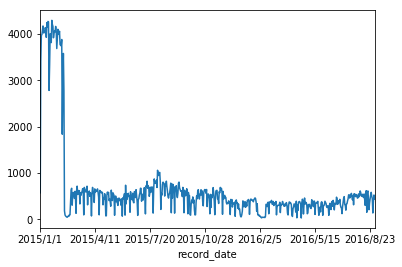

In [30]:
p1=p[p['user_id']==int(type1ids[0])]
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()
 

## 由于之前没有画纵坐标值，现在发现某些波动小的在1000左右，上下波动还是比较严重的，因此不合适直接用均值来做预测值，比较合适的做法是分离出比较一致的近期数据再做打算

In [72]:
flag=0
for id in type1ids:
    p1=p[p['user_id']==int(id)]
    for i in range(len(p1)-3,1,-1):
        delta=p1.power_consumption.iloc[i:].std()+1
        mean=p1.power_consumption.iloc[i:].mean()
        if(p1.power_consumption.iloc[i-1]>mean+10*delta):
            break
    p2=p1.iloc[i:,:]
    if(flag==0):
        p2.to_csv('type1.csv',index=False)
        flag=1
    else:
        p2.to_csv('type1.csv',index=False,mode='a',header=False)
    p1=p1.iloc[i:,:]
    p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
    ax=p1s.plot()
    fig=ax.get_figure()
    fig.savefig('./t1/'+str(id)+'.jpg')
    fig.clear()
    
    

### 用标准差的方法分离无法准确的分离出想要的“近期”，还是靠人眼识别好了

### 感觉要用分而治之的方法分析还要好几天的时间，为了利用上每天的提交机会，先对整体进行预测看看
    

In [2]:
pg=p.groupby(['record_date'],as_index=False).sum()

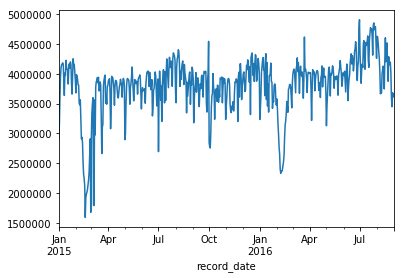

In [3]:

p1=pg
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

### 从上图可以看出春节期间有明显的下降，但对预测9月份没有帮助，所以保存到pg.csv后删除再读入pg

In [19]:
pg.to_csv('pg.csv',index=False)

606


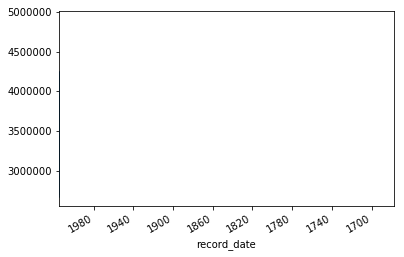

In [4]:
pg=pd.read_csv('./pg.csv',parse_dates=[0],infer_datetime_format=True)
p1=pg
print len(pg)
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

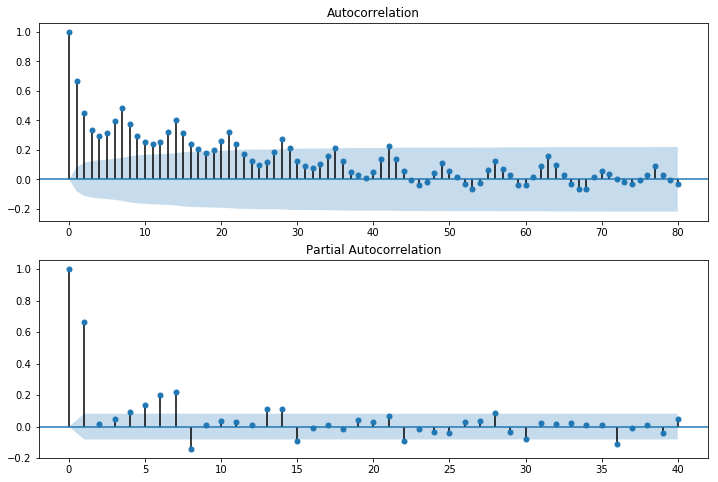

In [247]:
dta=pg.power_consumption.values
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)
plt.show()

In [239]:
adf_test(dta,'c')

Test Statistic                  -3.062338
p-value                          0.029469
Lags Used                       14.000000
Number of Observations Used    559.000000
Critical Value (5%)             -2.866724
Critical Value (1%)             -3.442102
Critical Value (10%)            -2.569531
dtype: float64

### 第一张自相关图表明电量有周期性，所以对周一到周日的数据分别建模或者做步长为7的差分
### 平稳序列的自相关系数会很快地衰减向零，AR模型的是指数衰减，MA模型的是1或2阶之后突变到0附近，而上图自相关说是指数衰减有点勉强，但单位根ADF检验表明确实可以接受其为平稳序列，且偏自相关截尾比较明显，可以考虑AR(14)模型

In [268]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(dta,lags=1))

(array([ 255.50981678]), array([  1.63418462e-57]))


### P值小于0.05，所以序列为平稳非白噪声序列。

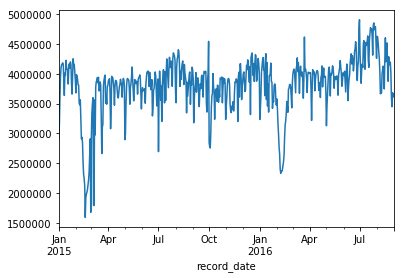

In [6]:
pg2=p.groupby(['record_date'],as_index=False).sum()
p1s2=pd.Series(pg2.power_consumption.values,index=pg2.record_date,name='power_consumption')
p1s2.plot()
plt.show()

In [7]:
dta2=pg2.power_consumption.values
adf_test(dta2,'c')

Test Statistic                  -3.939859
p-value                          0.001760
Lags Used                       15.000000
Number of Observations Used    593.000000
Critical Value (5%)             -2.866426
Critical Value (1%)             -3.441426
Critical Value (10%)            -2.569372
dtype: float64

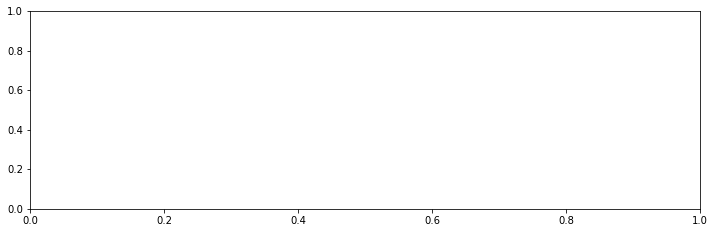

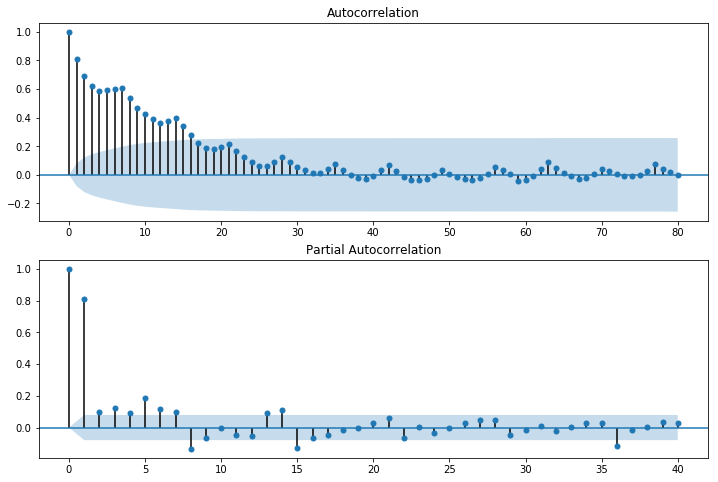

In [10]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta2,lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta2,lags=40,ax=ax2)
plt.show()

### 怎么不删除春节数据的结果反而更好看一点？p值更小。但自相关衰减的没有删除春节数据的快。

In [245]:
p1=pg
diff_1=p1.diff(1)
print(len(p1))
diff_1.dropna(inplace=True)
dta3=diff_1.power_consumption.values
adf_test(dta3,'c')

574


Test Statistic                -9.024187e+00
p-value                        5.668432e-15
Lags Used                      1.300000e+01
Number of Observations Used    5.590000e+02
Critical Value (5%)           -2.866724e+00
Critical Value (1%)           -3.442102e+00
Critical Value (10%)          -2.569531e+00
dtype: float64

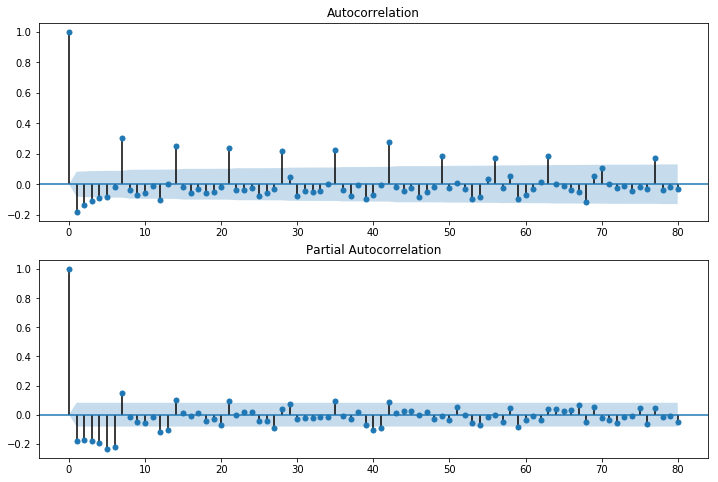

In [246]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta3,lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta3,lags=80,ax=ax2)
plt.show()

### 一阶差分后自相关拖尾，偏自相关截尾（？），单位根检验显著，认为序列平稳，用AR模型阶数多少都不合适，还是不做一阶差分的好

In [261]:
dta=dta.astype(np.float64)
arma_mod20 = sm.tsa.ARMA(dta,(14,0)).fit() 
print(arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic) 
arma_mod30 = sm.tsa.ARMA(dta,(14,1)).fit() 
print(arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic) 
arma_mod40 = sm.tsa.ARMA(dta,(15,0)).fit() 
print(arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic) 
arma_mod50 = sm.tsa.ARMA(dta,(15,1)).fit() 
print(arma_mod50.aic,arma_mod50.bic,arma_mod50.hqic)

(15827.531005229628, 15897.173075570741, 15854.694807001099)
(15826.36887801395, 15900.363577751381, 15855.230417396137)
(15824.225400288418, 15898.22010002585, 15853.086939670606)
(15826.13194689258, 15904.479276026332, 15856.691223885484)


In [14]:
dta2=dta2.astype(np.float64)
arma_mod15 = sm.tsa.ARMA(dta2,(15,0)).fit() 

D:\Anaconda3\envs\py27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NameError: name 'arma_mod40' is not defined

In [15]:
print(arma_mod15.aic,arma_mod15.bic,arma_mod15.hqic)

(16949.001437852683, 17024.002348403752, 16978.178296174479)


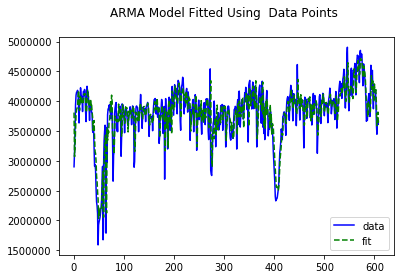

In [22]:
plt.figure(facecolor='white')
plt.title('ARMA Model Fitted Using  Data Points \n')
plt.plot(dta2, 'b-', label='data')
plt.plot(range(len(arma_mod15.fittedvalues)), arma_mod15.fittedvalues, 'g--', label='fit')
#plt.plot(range(len(data)), fit[:len(data)], 'r-', label='predict')
plt.legend(loc=4)
plt.show()

In [24]:
forecast,stderr ,conf_int =arma_mod15.forecast(30)

In [37]:
forecast

array([ 3771655.00878507,  3752859.77304656,  3587892.83326688,
        3521968.97202706,  3661967.44195177,  3655422.77660922,
        3681986.0995036 ,  3770759.92823551,  3753578.47450539,
        3647297.99251342,  3628394.86751586,  3707089.21434853,
        3698297.22385767,  3719994.38814653,  3773584.97026353,
        3769847.8774519 ,  3713092.83088237,  3702476.33980623,
        3745761.77991924,  3740940.31165919,  3752423.97436424,
        3790255.26934335,  3786051.72669411,  3751510.02131722,
        3749293.89792092,  3772152.95498521,  3768421.33614589,
        3775794.59135384,  3797823.75261994,  3796234.62657769])

In [29]:
pd.DataFrame(arma_mod15.arparams).to_csv('forecastparams.csv')

In [26]:
pd.DataFrame(forecast).to_csv('forecast.csv')

### 根据上面的结果，对于删除了春节的dta来说，AR(14)足够好了

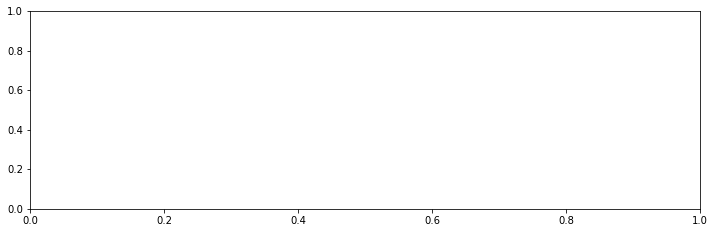

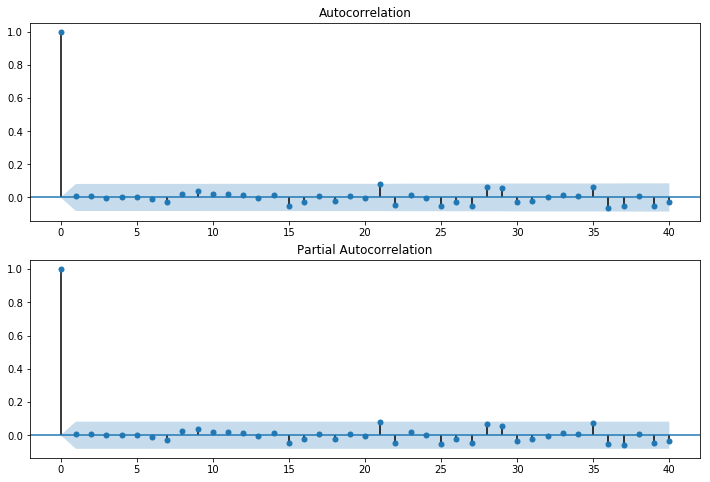

In [275]:
resid = arma_mod20.resid
fig = plt.figure(figsize=(12,8)) 
ax1 = fig.add_subplot(211) 
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212) 
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
plt.show()

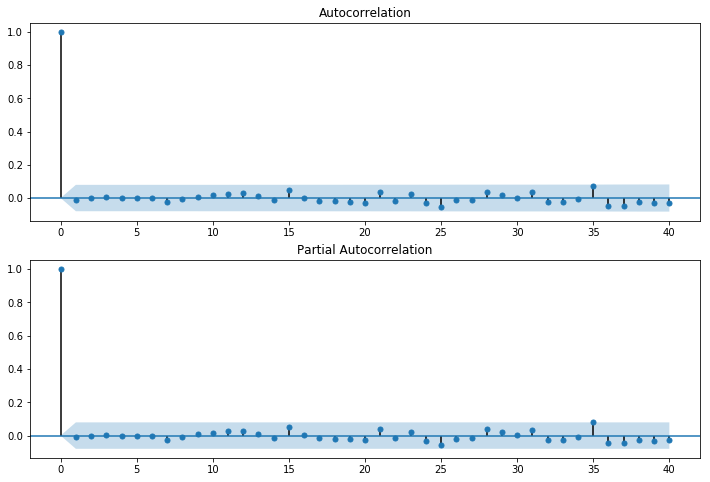

In [16]:
resid = arma_mod15.resid
fig = plt.figure(figsize=(12,8)) 
ax1 = fig.add_subplot(211) 
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212) 
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
plt.show()

## 残差基本为白噪声

In [278]:
print(acorr_ljungbox(resid,lags=1))
print(sm.stats.durbin_watson(resid))#当DW值显著的接近于O或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性。

(array([ 0.02141839]), array([ 0.88364492]))
1.95488170856


NormaltestResult(statistic=177.97960703833019, pvalue=2.250191013726903e-39)


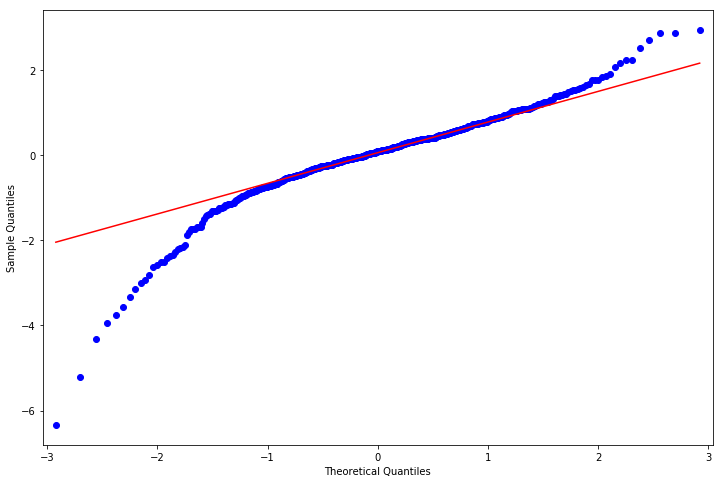

In [281]:
#这里使用QQ图，它用于直观验证一组数据是否来自某个分布，或者验证某两组数据是否来自同一（族）分布。
from statsmodels.graphics.api import qqplot
from scipy import  stats
print(stats.normaltest(resid))
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [282]:
# 残差序列Ljung-Box检验，也叫Q检验,prob值均大于0.05，所以残差序列不存在自相关性
r,q,p = sm.tsa.acf(resid, qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0   0.006093   0.021418  0.883645
2.0   0.006553   0.046236  0.977147
3.0  -0.001097   0.046933  0.997334
4.0   0.004388   0.058100  0.999586
5.0   0.000289   0.058149  0.999958
6.0  -0.010812   0.126199  0.999960
7.0  -0.025997   0.520278  0.999369
8.0   0.022507   0.816188  0.999164
9.0   0.038158   1.668205  0.995696
10.0  0.018606   1.871152  0.997236
11.0  0.022768   2.175563  0.997778
12.0  0.012588   2.268789  0.998869
13.0 -0.004178   2.279077  0.999530
14.0  0.012642   2.373433  0.999765
15.0 -0.049908   3.846628  0.998198
16.0 -0.025623   4.235631  0.998434
17.0  0.007989   4.273519  0.999195
18.0 -0.023682   4.607017  0.999352
19.0  0.011035   4.679561  0.999651
20.0 -0.000787   4.679930  0.999835
21.0  0.083099   8.808554  0.990642
22.0 -0.042876   9.909654  0.987106
23.0  0.016968  10.082405  0.990756
24.0 -0.004561  10.094913  0.994144
25.0 -0.052561  11.758645  0.988405
26.0 -0.027296  12.208173  0

In [296]:
predict_dta = arma_mod20.predict(14, len(p1)+30, dynamic=True)
plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
plt.show()

[ 4011300.8082078   3888284.85851143  3800783.77842488  3778255.3180919
  3938780.80332586  3979417.38649032  4047866.63080444  3995891.4590784
  3970232.90478922  3897009.2065741   3867052.64211885  3914901.63219106
  3947474.32544013  3995955.35253679  3974351.84546839  3946502.03065212
  3896021.90437683  3877066.06268899  3900925.82402617  3928401.37760062
  3954131.87794517  3950232.94376934  3937430.71956621  3909852.31729295
  3896803.46716385  3903961.3684893   3919096.24121397  3934030.68654959
  3935309.53034611  3927969.04910945  3911055.06299927  3900824.71761795
  3902335.04897224  3910967.81767765  3919979.24495207  3922732.63238758
  3919386.40196015  3910090.94946151  3903321.76792861  3902766.32112125
  3907075.98156402  3912263.16143723  3914713.07764278  3913264.68798451
  3907994.01356144  3903361.03997747  3902078.80087469  3903991.95546589
  3906920.51978547  3908763.91438496  3908293.29787717  3905427.1839935
  3902472.49180759  3901237.84991569  3901953.6517337 

In [303]:
predict_dta = arma_mod20.predict(14, len(p1)+30, dynamic=True)

574

In [19]:
predict_dta=arma_mod15.predict(len(dta2), len(dta2)+30, dynamic=False)
pd.DataFrame(predict_dta).to_csv('predict15.csv')

In [304]:
predict_dta = arma_mod20.predict(len(dta), len(dta)+30, dynamic=True)
pd.DataFrame(predict_dta).to_csv('predict.csv')

In [307]:
predict_dta = arma_mod20.predict(14, len(dta)+30, dynamic=True)

In [308]:
pd.DataFrame(predict_dta).to_csv('predict2.csv')

In [28]:
adf_test(dta,'c')

Test Statistic                  -3.062338
p-value                          0.029469
Lags Used                       14.000000
Number of Observations Used    559.000000
Critical Value (5%)             -2.866724
Critical Value (1%)             -3.442102
Critical Value (10%)            -2.569531
dtype: float64

In [32]:
adf_test(dta,'ct')

Test Statistic                  -3.688302
p-value                          0.023139
Lags Used                       14.000000
Number of Observations Used    559.000000
Critical Value (5%)             -3.418373
Critical Value (1%)             -3.975057
Critical Value (10%)            -3.131688
dtype: float64

### 根据上述单位根检验，可以认为有常数项，趋势项则有帮助，但不明显，从数据上看，7/8月份的峰值明显高于以往，从每个厂家的用电量来看，七八月份有部分厂家停工歇业，有部分厂家开工开始营业，要预测，最好把停工的厂家数据剔除，然后把开工的厂家单独预测，但这些厂家刚开始开工，如何预测呢？

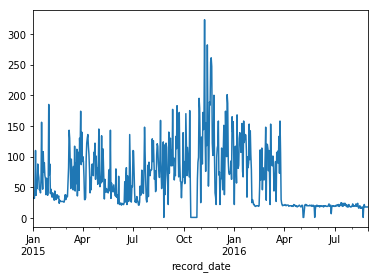

In [35]:
p1=p[p['user_id']==82]
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

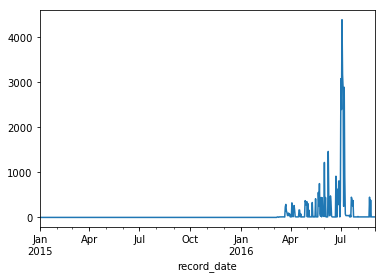

In [36]:
p1=p[p['user_id']==821]
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

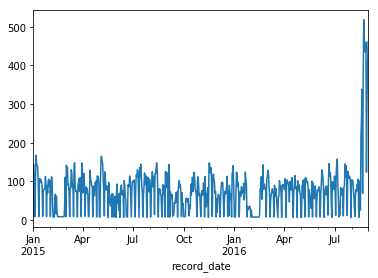

In [43]:
p1=p[p['user_id']==1217]
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

### 对这种最后几天突然变大的无法预测其值，无法确定是扩大了产能还是异常值

In [34]:
def plotcolor(typeid):
    type1ids=getids(typeid)
    path='./typecolor'+str(typeid)+'/'
    if(not os.path.isdir(path)):
        os.mkdir(path)
    for id in type1ids:
        p1=p[p['user_id']==int(id)]
        p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
        ax=p1s.plot()
        fig=ax.get_figure() 
        fig.savefig(path+str(id)+'.jpg')
        fig.clear()
    
    

### 要预测，不仅去掉停工的，也得去掉中间开工的，对中间开工的也只能单独预测，好在中间开工的数据比较多；还得去掉只有几个峰值点的

In [35]:
plotcolor(14)

In [45]:
p1=p[p['user_id']==15]

In [47]:
p1=p1[p1.power_consumption<1982]

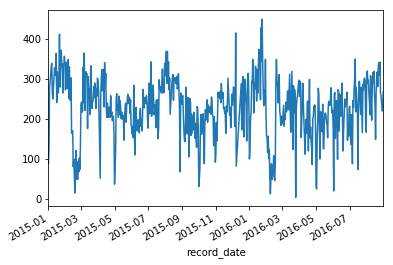

In [48]:
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

### 像上图15号厂家的数据就适合去除孤立点后再做预测

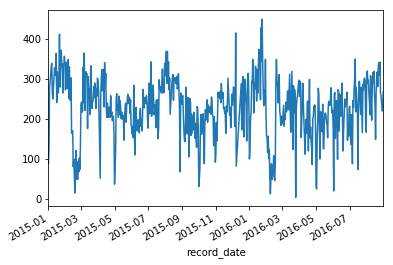

In [74]:
p1=p[p['user_id']==15]
p1=p1[p1.power_consumption<1000]
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

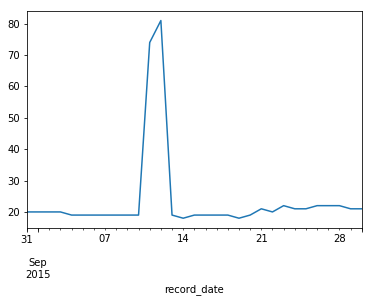

In [73]:
p1=p[p['user_id']==283]
p1=p1[(p1.record_date>'2015-08-30') & (p1.record_date<'2015-10-01') ]
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

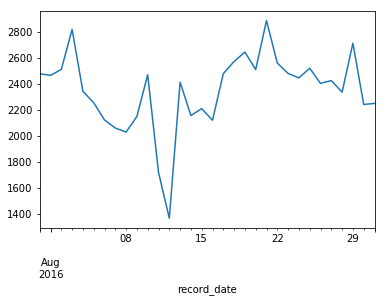

In [70]:
p1=p[p['user_id']==237]
p1=p1[(p1.record_date>'2016-07-30') & (p1.record_date<'2016-10-01') ]
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

### 每天才几十几百度的，对整体影响大吗？计算每个厂家的日均用电量，总用电量占所有用电量的百分比。日均600以上的500家厂子占95%，

In [63]:
pg=p.groupby(['user_id'],as_index=False).sum()

In [65]:
pg.to_csv('pgpower.csv',index=False)

In [75]:
plotcolor(17)

### 有几个图漏了，补上

In [30]:
import numpy as np
ids=[]
length=0
for i in range(16):
    idi=getids(i+1)
    ididf=pd.DataFrame(idi)
    ididf['type']=i+1
    length=length+len(idi)
    ids.append(ididf)
dfs=pd.concat(ids)
dfs.columns=['user_id','type']
dfs.user_id=dfs.user_id.astype(np.int64)
dfpower=pd.read_csv('pgpower.csv',usecols=[0,1])
dfall=pd.merge(dfpower,dfs,on=['user_id'],how='left')
dfall=dfall.fillna(0)
dfmiss=dfall[dfall['type']==0]
for i in dfmiss.user_id:
    p1=p[p['user_id']==i]
    p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
    ax=p1s.plot()
    ax.set_axis_off()
    fig=ax.get_figure()
    fig.savefig('./fgmiss/'+str(i)+'.jpg')
    fig.clear()

### 最近一个月的总值排序

In [ ]:
import numpy as np
ids=[]
length=0
for i in range(16):
    idi=getids(i+1)
    ididf=pd.DataFrame(idi)
    ididf['type']=i+1
    length=length+len(idi)
    ids.append(ididf)
dfs=pd.concat(ids)
dfs.columns=['user_id','type']
dfs.user_id=dfs.user_id.astype(np.int64)
dfpower=pd.read_csv('pgpower.csv',usecols=[0,1])
dfall=pd.merge(dfpower,dfs,on=['user_id'],how='left')
dfall=dfall.fillna(0)
dfmiss=dfall[dfall['type']==0]
for i in dfmiss.user_id:
    p1=p[p['user_id']==i]
    p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
    ax=p1s.plot()
    ax.set_axis_off()
    fig=ax.get_figure()
    fig.savefig('./fgmiss/'+str(i)+'.jpg')
    fig.clear()

In [32]:
dfall.to_csv('dfall.csv')

### 分析第一个厂家的平稳性

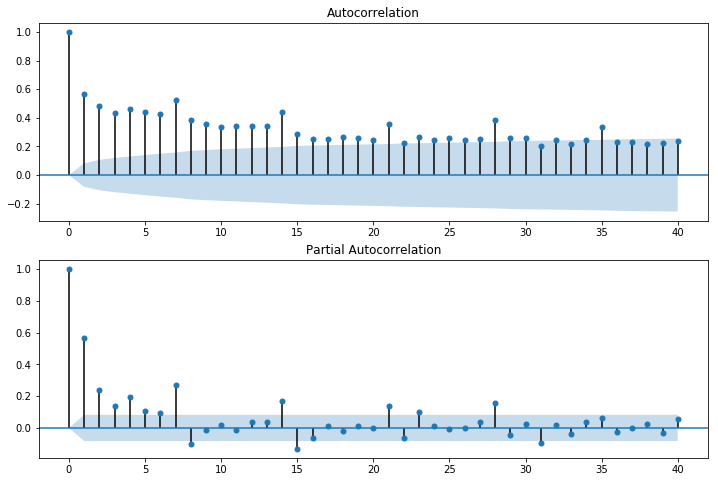

In [176]:
p1=p[p['user_id']==1]
p1=p1[p1.power_consumption<1000]
dta=p1.power_consumption.values
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)
plt.show()

In [177]:
adf_test(dta,'c')

Test Statistic                  -2.991228
p-value                          0.035722
Lags Used                       15.000000
Number of Observations Used    546.000000
Critical Value (5%)             -2.866848
Critical Value (1%)             -3.442384
Critical Value (10%)            -2.569597
dtype: float64

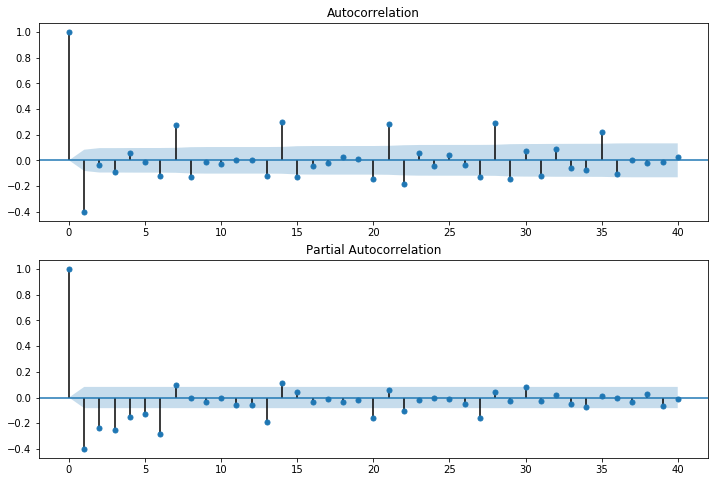

In [187]:
diff_7=p1.diff(1)
diff_7.dropna(inplace=True)
dta=diff_7.power_consumption.values
adf_test(dta,'c')


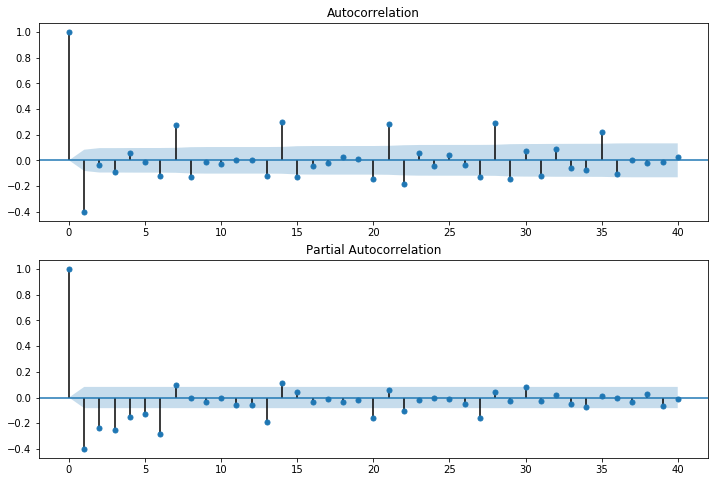

In [186]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)
plt.show()

### 为什么自相关图没有很快衰减到0但adf检验却表明没有单位根（平稳）？很快衰减到0并不意味着等于0.
#### 有单位跟则二阶矩随时间改变而改变，所以不平稳。

In [136]:
pwd

u'd:\\My Documents\\Desktop\\tianchi'

#### AR(p)模型偏自相关系数P阶截尾

In [113]:
aaa=dfall[dfall['user_id']==514]['type']

In [127]:

dfall[]

,user_id,power_consumption,type
0,1416,609162221,8.0
1,175,273792662,8.0
2,174,223937019,8.0
3,90,90571615,6.0
4,1262,54683404,1.0
5,129,51248588,6.0
6,1307,36842773,6.0
7,1310,36842773,6.0
8,275,17179879,3.0
9,1124,15635486,6.0
